<a href="https://colab.research.google.com/github/CookieDelta/KC_NLP/blob/main/Practica_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica final NLP KeepCoding


# Introducción  

Este notebook forma parte de la práctica de NLP, donde se evaluarán distintas etapas del análisis de sentimiento. Se utilizará el dataset **Amazon Reviews - Musical Instruments (5-core)**, que contiene reseñas de productos musicales con calificaciones de 1 a 5 estrellas.  

El objetivo es explorar, preprocesar y analizar los datos para entrenar modelos de clasificación binaria del sentimiento, evaluando su desempeño mediante métricas estándar.  


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from google.colab import drive

In [74]:
# Carga del dataset
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/reviews_Musical_Instruments_5.json"

data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

#carga df
df = pd.DataFrame(data)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# Mostrar primeras filas y estructura
display(df.head())
display(df.info())

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10261 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


None

In [76]:
# Cardinalidad del vocabulario
def get_vocab_size(texts):
    words = " ".join(texts).split()
    return len(set(words))

vocab_size = get_vocab_size(df['reviewText'].dropna().astype(str))
print(f"Cardinalidad del vocabulario: {vocab_size}")

Cardinalidad del vocabulario: 57714


<ipython-input-77-4fb97301743a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=df, palette='viridis')


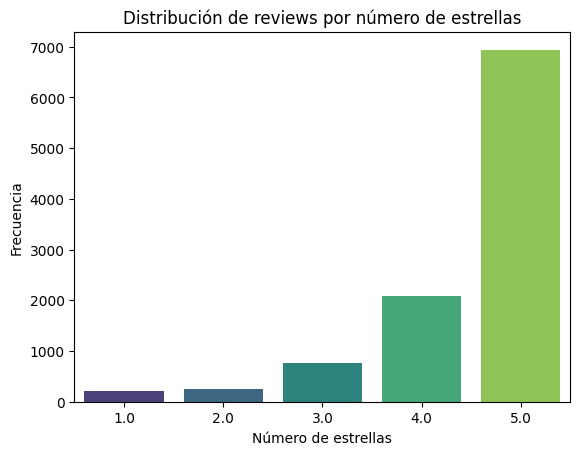

In [77]:
# Distribución de reviews por número de estrellas
sns.countplot(x='overall', data=df, palette='viridis')
plt.xlabel("Número de estrellas")
plt.ylabel("Frecuencia")
plt.title("Distribución de reviews por número de estrellas")
plt.show()

<ipython-input-78-69a9157e701d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


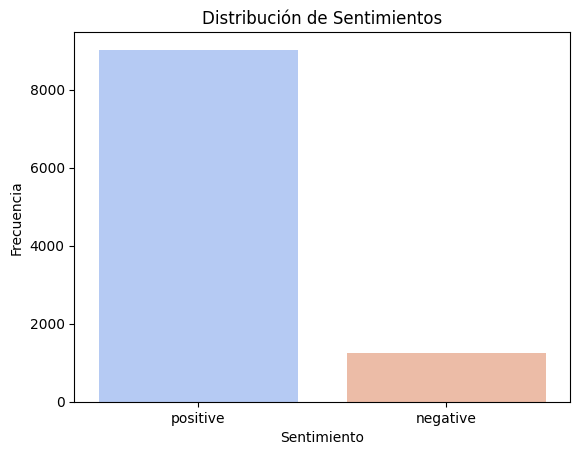

In [78]:
# Nº de reviews positivas y negativas
threshold = 3
df['sentiment'] = df['overall'].apply(lambda x: 'positive' if x > threshold else 'negative')

sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.title("Distribución de Sentimientos")
plt.show()


<ipython-input-79-e28d08b7f805>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(n_gram_counts.values()), y=list(n_gram_counts.keys()), palette='magma')


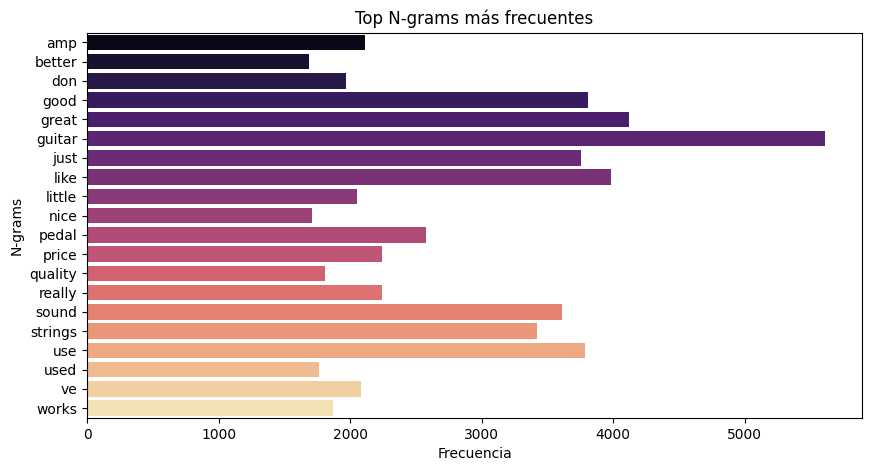

In [79]:
# N-grams más frecuentes
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['reviewText'].dropna().astype(str))
n_gram_counts = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis=0)).ravel()))

plt.figure(figsize=(10, 5))
sns.barplot(x=list(n_gram_counts.values()), y=list(n_gram_counts.keys()), palette='magma')
plt.xlabel("Frecuencia")
plt.ylabel("N-grams")
plt.title("Top N-grams más frecuentes")
plt.show()

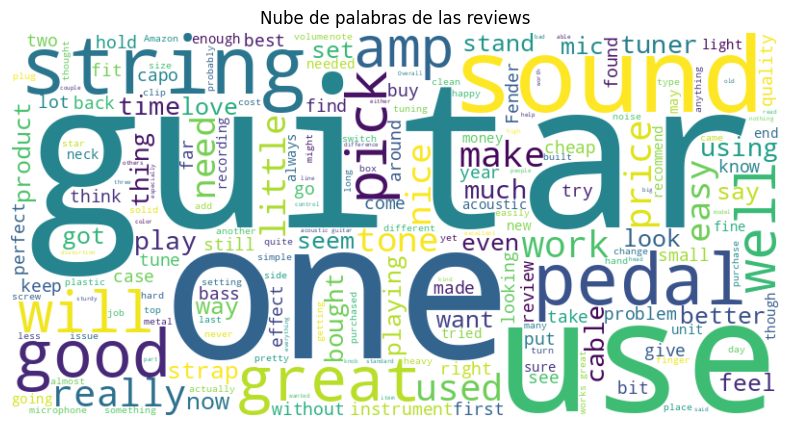

In [80]:
# Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['reviewText'].dropna().astype(str)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras de las reviews")
plt.show()


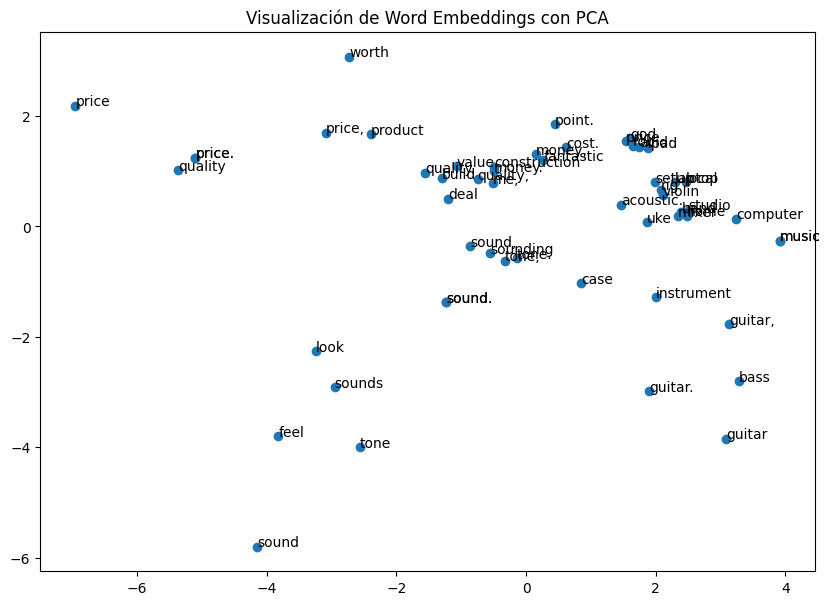

In [81]:
# Word2Vec y visualización de embeddings
sentences = [review.split() for review in df['reviewText'].dropna().astype(str)]
model = Word2Vec(sentences, vector_size=50, window=5, min_count=2, workers=4)

words = ["guitar", "sound", "quality", "music", "price"]
word_vectors = []
labels = []
for word in words:
    if word in model.wv:
        word_vectors.append(model.wv[word])
        labels.append(word)
        for similar_word, _ in model.wv.most_similar(word, topn=10):
            word_vectors.append(model.wv[similar_word])
            labels.append(similar_word)

word_vectors = np.array(word_vectors)
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
for i, label in enumerate(labels):
    plt.annotate(label, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
plt.title("Visualización de Word Embeddings con PCA")
plt.show()


# Conclusiones de la exploración

1. El dataset tiene una distribución sesgada hacia calificaciones altas, indicando una tendencia positiva en las reviews.
2. La cardinalidad del vocabulario muestra que hay una diversidad léxica significativa en las reseñas.
3. Los N-grams más frecuentes destacan términos relacionados con calidad y sonido, teniendo mayor protagonismo lo relacionado con guitarras (se ve pedal y cuerdas también).
4. La visualización de embeddings muestra la relación semántica entre palabras clave del dominio musical, es decir, la relación que hay entre ellas.


# Preprocesado de texto

In [83]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd


In [84]:
# Download necessary NLTK data files
!pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [85]:
# Funciones de procesado de texto

# Eliminar puntuación y hacer lower
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower()

def to_lowercase(text):
    return text.lower()
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])

# limpieza URLs, numeros, especiales
def clean_text(text):
    #URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #numeros
    text = re.sub(r'\d+', '', text)

    # caracterers especiales, espacios
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Todo combinado
def preprocess_review(text):
    text = remove_punctuation(text)
    text = clean_text(text)
    text = remove_stopwords(text)
    text = to_lowercase(text)
    return text

# Aplicar
def preprocess_reviews(df, text_column):
    df[text_column] = df[text_column].apply(preprocess_review)
    return df




In [86]:
# Download necessary NLTK data files
nltk.download('punk_tab')
nltk.download('stopwords')

# Preprocess reviews in the DataFrame
df = preprocess_reviews(df, 'reviewText')
print(df.head())

[nltk_data] Error loading punk_tab: Package 'punk_tab' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  much write exactly supposed filters pop sounds...      5.0   
1  product exactly quite affordablei realized dou...      5.0   
2  primary job device block breath would otherwis...      5.0   
3  nice windscreen protects mxl mic prevents pops...      5.0   
4  pop filter great looks performs like studio fi...      5.0   

                   

In [87]:
df = pd.DataFrame(df)

In [88]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",much write exactly supposed filters pop sounds...,5.0,good,1393545600,"02 28, 2014",positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",product exactly quite affordablei realized dou...,5.0,Jake,1363392000,"03 16, 2013",positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",primary job device block breath would otherwis...,5.0,It Does The Job Well,1377648000,"08 28, 2013",positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",nice windscreen protects mxl mic prevents pops...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",pop filter great looks performs like studio fi...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",positive


In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# mapeo valores
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# BoW
vectorizer = CountVectorizer()

# Convert the reviews to BoW features
X = vectorizer.fit_transform(df['reviewText'])

#  labels (sentiment: 1 for positive, 0 for negative)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
svm_model = SVC(kernel='linear')  # You can adjust the kernel to 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)


print("SVM Model Evaluation:")
print(report_svm)

print("Random Forest Model Evaluation:")
print(report_rf)


SVM Model Evaluation:
{'0': {'precision': 0.3951612903225806, 'recall': 0.4016393442622951, 'f1-score': 0.3983739837398374, 'support': 244.0}, '1': {'precision': 0.9191135734072022, 'recall': 0.9170812603648425, 'f1-score': 0.9180962921970116, 'support': 1809.0}, 'accuracy': 0.855820750121773, 'macro avg': {'precision': 0.6571374318648915, 'recall': 0.6593603023135688, 'f1-score': 0.6582351379684245, 'support': 2053.0}, 'weighted avg': {'precision': 0.8568416021102477, 'recall': 0.855820750121773, 'f1-score': 0.8563270553418969, 'support': 2053.0}}
Random Forest Model Evaluation:
{'0': {'precision': 0.5, 'recall': 0.01639344262295082, 'f1-score': 0.031746031746031744, 'support': 244.0}, '1': {'precision': 0.882640586797066, 'recall': 0.9977888336097291, 'f1-score': 0.9366891541255838, 'support': 1809.0}, 'accuracy': 0.8811495372625426, 'macro avg': {'precision': 0.691320293398533, 'recall': 0.50709113811634, 'f1-score': 0.4842175929358078, 'support': 2053.0}, 'weighted avg': {'precisio

# Modelos

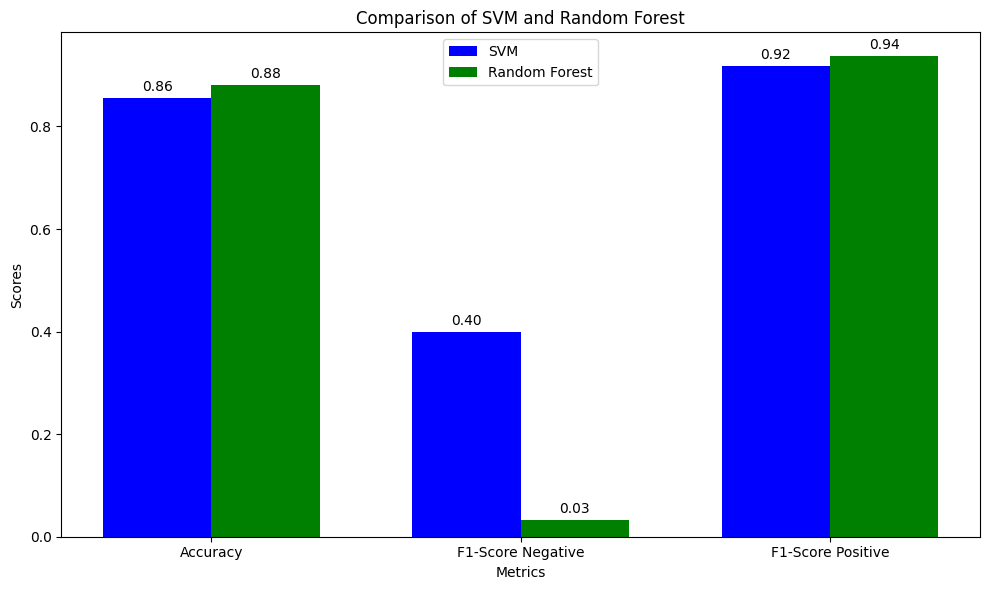

In [90]:
# Extract Accuracy and F1-Scores for both models
accuracy_svm = report_svm['accuracy']
accuracy_rf = report_rf['accuracy']

f1_svm_negative = report_svm['0']['f1-score']
f1_rf_negative = report_rf['0']['f1-score']

f1_svm_positive = report_svm['1']['f1-score']
f1_rf_positive = report_rf['1']['f1-score']

# Prepare data for plotting
labels = ['Accuracy', 'F1-Score Negative', 'F1-Score Positive']
svm_metrics = [accuracy_svm, f1_svm_negative, f1_svm_positive]
rf_metrics = [accuracy_rf, f1_rf_negative, f1_rf_positive]

# Create side-by-side bar chart
x = np.arange(len(labels))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data for SVM and Random Forest
rects1 = ax.bar(x - width/2, svm_metrics, width, label='SVM', color='blue')
rects2 = ax.bar(x + width/2, rf_metrics, width, label='Random Forest', color='green')

# Add text labels, title, and axis labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of SVM and Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the values on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

**Conclusión:**

Antes de analizar los resultados, es importante entender qué representan las métricas precisión, recall y f1-score:

- **Precisión**: Mide la exactitud de las predicciones positivas. Es el porcentaje de veces que el modelo predice correctamente una clase positiva, en relación con todas las predicciones positivas que hizo.

- **Recall**: Mide la capacidad del modelo para encontrar todas las instancias positivas. Es el porcentaje de veces que el modelo detecta correctamente las instancias positivas, en relación con todas las instancias que realmente son positivas.

- **F1-score**: Es una métrica combinada que equilibra precisión y recall, y es especialmente útil cuando hay un desbalance entre las clases. Es la media armónica entre precisión y recall.
### **Modelo SVM:**
- **Precisión**: 85.58% general. Alta precisión para sentimientos positivos (91.91%), pero baja para negativos (39.52%).
- **Recall**: Muy alto para positivos (91.71%), pero bajo para negativos (40.16%).
- **F1-score**: 65.82% promedio, con buen balance, aunque sesgado hacia el sentimiento positivo.

### **Modelo Random Forest:**
- **Precisión**: 88.11% general. Buena precisión para positivos (88.26%), pero solo 50% para negativos.
- **Recall**: Excelente para positivos (99.78%), pero muy bajo para negativos (1.64%).
- **F1-score**: 48.42% promedio, con un rendimiento muy desequilibrado.

### **Análisis Comparativo:**
- **SVM** tiene un mejor **balance** entre las dos clases, mientras que **Random Forest** se destaca solo en los sentimientos positivos pero falla al clasificar negativos.

### **Conclusión Final:**
Aunque **Random Forest** tiene buen desempeño en positivos, **SVM** es el modelo más equilibrado y con mayor **precisión general** (85.58%), por lo que es el modelo más adecuado para este caso.